# Fox-Li Cavity Simulation: Quasi-Ince-Gaussian Mode Formation

This tutorial demonstrates the Fox-Li iterative method for finding cavity eigenmodes
in a semi-degenerate laser resonator configuration. Under specific conditions, the
cavity supports **quasi-Ince-Gaussian modes** (quasi-IGᵉ₉₃ in this case) - modes
that are nearly invariant under propagation despite not being true IG eigenmodes.

> **Quasi-IG vs True IG Modes**
>
> True Ince-Gaussian modes with closed nodal lines cannot be excited with single-lobe
> pumping away from degeneracy: there will always exist a mode without closed nodal
> lines that has better overlap with the pump (gain-matching criterion). The quasi-IG
> patterns observed here only emerge near cavity degeneracies.
>
> For details, see: N. Barré, M. Romanelli, and M. Brunel,
> ["Role of cavity degeneracy for high-order mode excitation in end-pumped
> solid-state lasers"](https://doi.org/10.1364/OL.39.001022), Opt. Lett. **39**, 1022-1025 (2014).

## Physical Setup

We simulate a laser cavity with:
- A flat mirror with gain medium (near field)
- A curved output coupler with aperture (far field)
- Cavity length close to the stability boundary (semi-degenerate)

The Fox-Li method iteratively propagates the field through the cavity until
convergence to the eigenmode.

In [1]:
using FluxOptics, CairoMakie
using CUDA  # Comment if you don't have CUDA
using Random
Random.seed!(15);  # Determinist example

## Initial Field: Speckle Pattern

We start with a random speckle pattern as initial condition. This generic field
contains contributions from all cavity modes - the iterative process will
select the dominant eigenmode through preferential amplification.

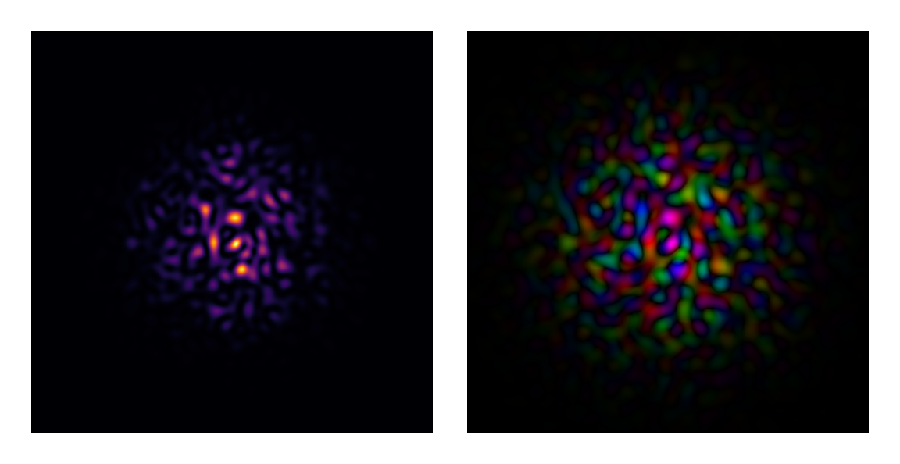

In [2]:
ns = 512, 512
ds = 4.0, 4.0

λ = 1.064
NA = 0.01

w0 = 500.0

speckle_dist = generate_speckle(ns, ds, λ, NA; envelope = Gaussian(w0))
u0 = ScalarField(speckle_dist, ds, λ)
u0 = cu(u0)  # Comment if you don't have CUDA
normalize_power!(u0, 1e-1)

visualize(u0, (intensity, complex); colormap=(:inferno, :dark), height=200)

## Gain Medium Configuration

The gain sheet provides selective amplification with saturable gain dynamics.
The off-center Gaussian pump profile (xc = 140 µm) breaks the cylindrical symmetry.

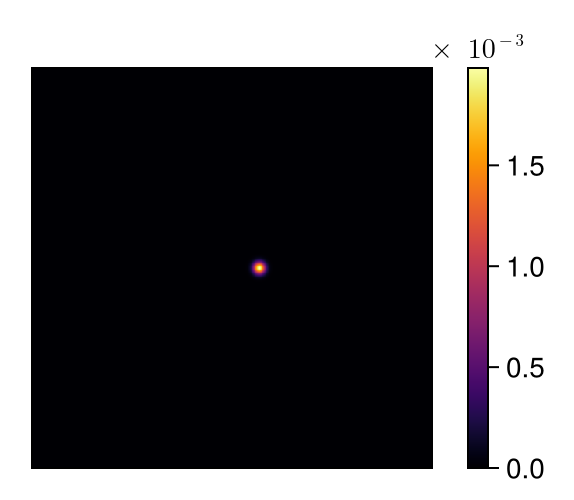

In [3]:
dz = 1000.0
Isat = 1.0
g0m = 2e-3
wg = 30.0
xc = 140.0
gain = GainSheet(u0, dz, Isat, (x, y) -> g0m * exp(-((x-xc)^2+y^2)/wg^2))

visualize(gain, identity; colormap=:inferno, show_colorbars=true, height=200)

## Cavity Geometry: Semi-Degenerate Configuration

The cavity length ℓ ≈ 101 mm is close to the half-degenerate condition (ℓ = Rc/2),
where the stability parameter approaches unity. This near-instability regime supports
complex transverse mode structures.

We use a magnification factor of 2 between the two mirrors to properly sample
the field at both ends of the cavity.

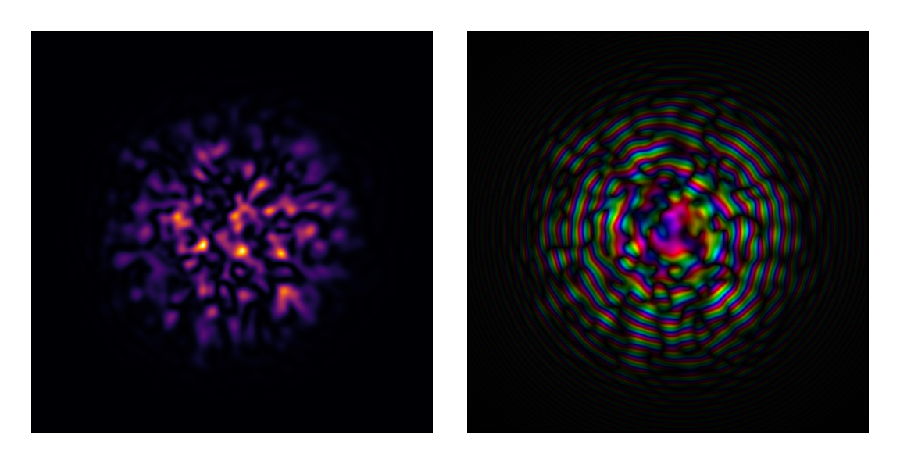

In [4]:
ℓ = 101000.0  # Close to half-degenerate cavity

s = 2
ds′ = s .* ds

p12 = ParaxialProp(u0, ds′, ℓ; use_cache = true)  # Magnification ×2
p21 = ParaxialProp(u0, ds′, ds, ℓ; use_cache = true)

half_cavity = gain |> p12

uf = half_cavity(u0).out

visualize(uf, (intensity, complex); colormap=(:inferno, :dark), height=200)

## Output Coupler: Spherical Mirror with Aperture

The output mirror has 98% reflectivity and 200 mm radius of curvature.
The aperture prevents the field from overflowing the computational grid,
which would lead to numerical instabilities during iteration.

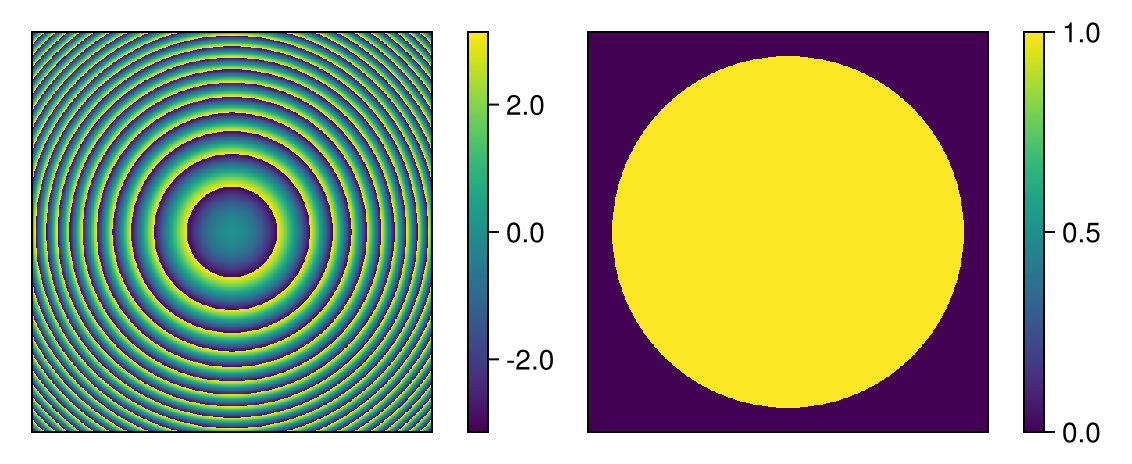

In [5]:
R = 0.98
Rc = 200000.0
aperture_radius = 1800.0
mirror = TeaReflector(uf, (x, y) -> -(x^2+y^2)/(2*Rc); r = -sqrt(R))
mirror_phase = phase(cis.(2π/λ .* get_data(mirror)))
aperture = Mask(uf, (x, y) -> x^2 + y^2 < aperture_radius^2 ? 1.0 : 0.0)

cavity = half_cavity |> mirror |> aperture |> p21 |> (; inplace = true)

visualize(((mirror_phase, aperture),), real; show_colorbars=true, height=200)

## Fox-Li Iteration: Eigenmode Convergence

We iteratively propagate the field through the complete cavity round-trip.
Each iteration consists of: gain → propagation → mirror+aperture → back-propagation.
After ~5000 iterations, the field converges to the cavity eigenmode.

In [6]:
u0c = copy(u0)
utmp = u0c
cavity(utmp);  # Warm-up for accurate timing

@time for i in 1:5000
    utmp = cavity(utmp).out
end

  3.163512 seconds (9.68 M allocations: 395.661 MiB, 2.27% gc time)


## Converged Eigenmode: Quasi-Ince-Gaussian IGᵉ₉₃

The converged mode exhibits an elliptical intensity pattern reminiscent of
Ince-Gaussian modes. This quasi-IG mode only exists near the cavity degeneracy point
and maintains its structure approximately through propagation.

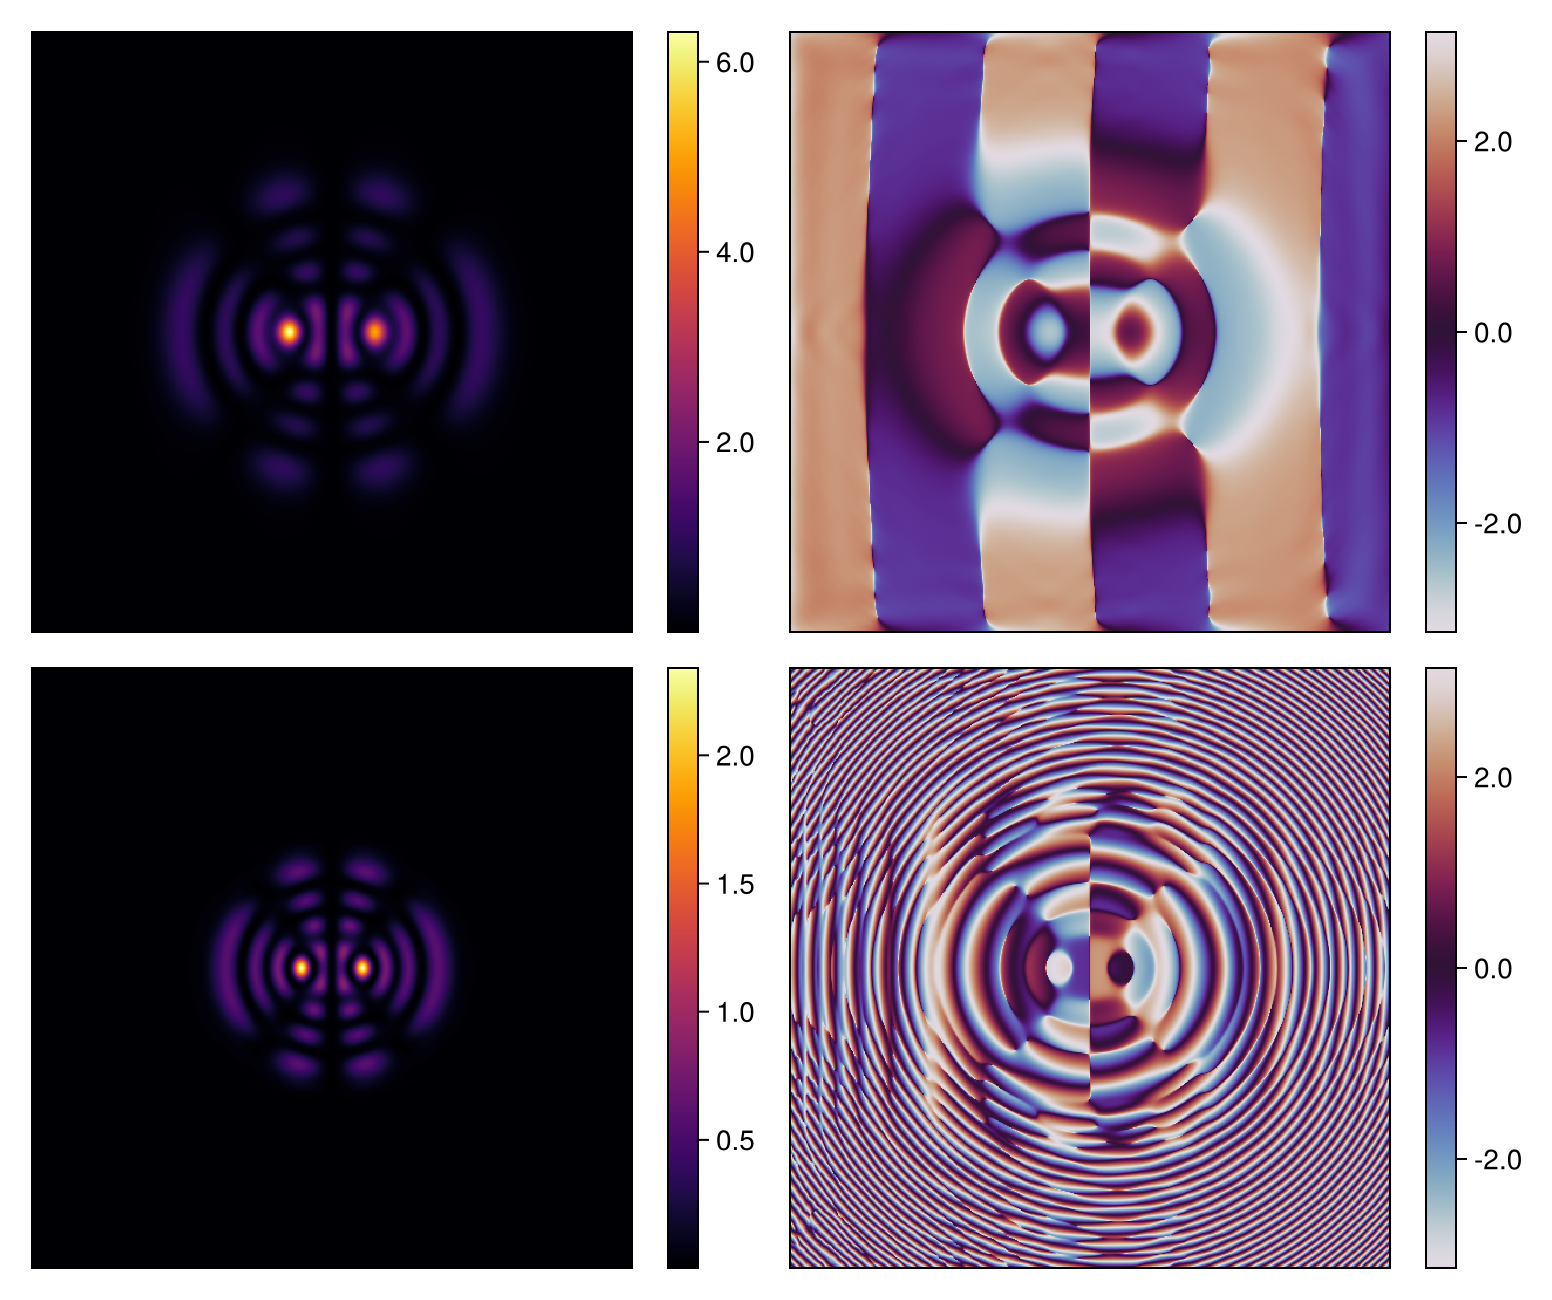

In [7]:
u_near = cavity(utmp).out
u_mirror = half_cavity(u_near).out

visualize((u_near, u_mirror), (intensity, phase); colormap=(:inferno, :twilight), show_colorbars=true, height=300)

## Far-Field Characterization

Propagating the eigenmode to twice the cavity length reveals the far-field intensity
distribution and phase structure.

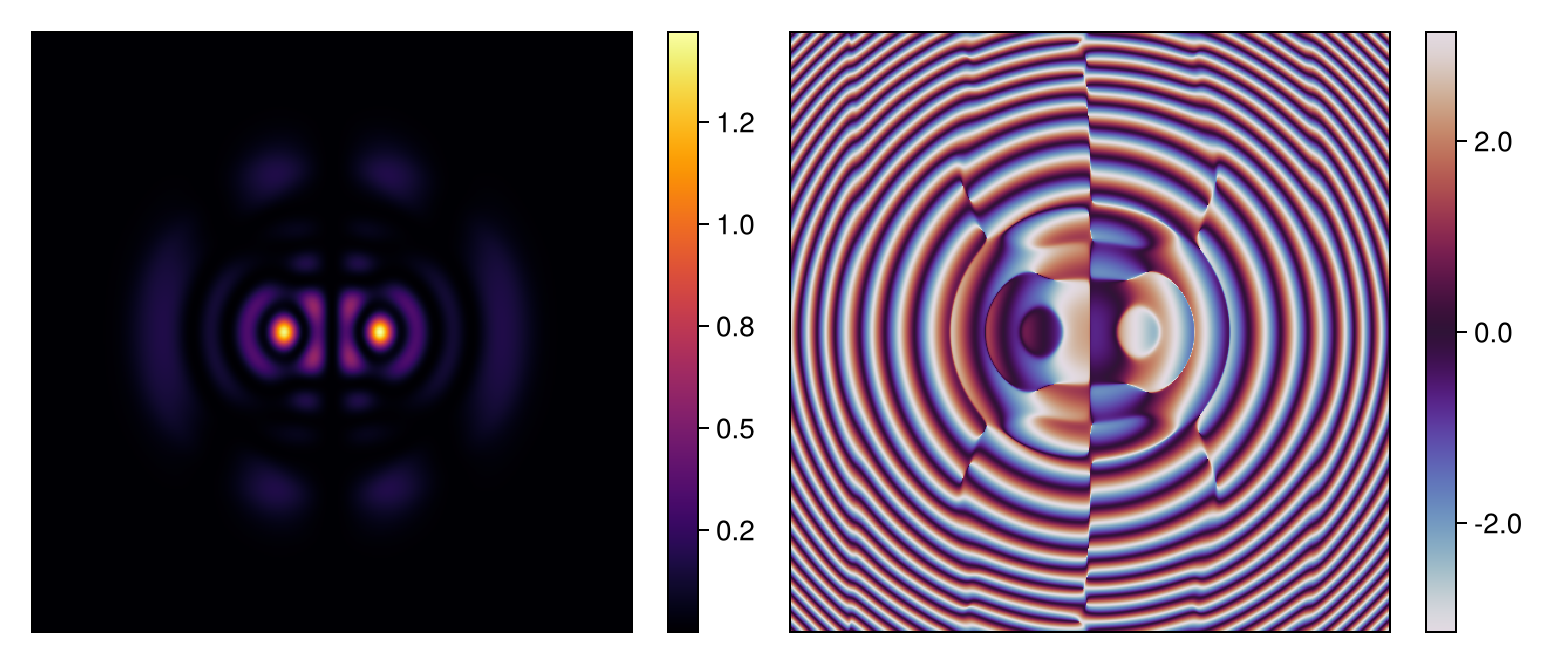

In [8]:
p_far = ParaxialProp(u_near, 2 .* ds, 2*ℓ; use_cache = true)
u_far = propagate(u_near, p_far, Forward)

visualize(u_far, (intensity, phase); colormap=(:inferno, :twilight), show_colorbars=true, height=300)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*